# Salience Analysis (Aggregate)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from matplotlib.ticker import MultipleLocator

# MEDIA & USERS

# Step 1 - import dataset

We import the datasets needed to calculate media salience: 
1. The immigration_df - containing all unique urls related to immigration 
2. The climate_df – containing all unique urls related to climate 
3. The url_df – containing the whole url sharing in France and the dates of sharing 

To gather the output and our calculation we import: 
1. The df – the general dataset containing all saliences for media, parties, and users for each timeperiod – here is where we will put the output of the analysis. 
2. time_counts_df - operational dataset to count immigration, climate, and total articles per time period


*Please note that originally we had calculated salience for users as well starting from the Favjeron and Ramaciotti (2023) dataset but then refrained from including this aspect in the thesis*

#### Input df

In [2]:
url_df = pd.read_csv("/.../FULL_media_france_URL_SHARING_with_titles_2017_2019.zip",compression="zip")
immigration_df = pd.read_csv('/.../FULL_media_france_UNIQUE_URLs_IMMIGRATION.zip', compression = 'zip')
climate_df = pd.read_csv('/.../FULL_media_france_UNIQUE_URLs_CLIMATE.zip', compression = 'zip')
url_df_users = url_df.copy() # creato copy - the first is used to detect pure media salience, the second to detect salience according to user's sharing behaviour

#### Output and operational df

In [3]:
df = pd.read_csv('/.../0_general_salience_across_time.csv')
time_counts_df = pd.read_csv('/.../general_time_periods_df.csv')

In [4]:
url_df.head(1)

,hashed_id,normalized_url,domain,datetime,normalized_url_phrases
0,34aa3c64ece5d8f88c2db3e2163946b4,ouest-france.fr/bretagne/rennes-35000/rennes-i...,ouest-france.fr,2019-07-20T14:21:37,rennes ils tendent un guet apens aux pompiers ...


In [5]:
immigration_df.head(1)

,normalized_url_phrases,topic,debate,theme,normalized_url,domain
0,patrick weil sur le projet de loi immigration ...,348,immigration,immigration law – france,europe1.fr/emissions/linvite-de-patrick-cohen/...,europe1.fr


In [6]:
climate_df['debate'] = 'climate'
climate_df.head(1)

,normalized_url_phrases,topic,theme,normalized_url,domain,debate
0,rechauffement climatique arctique permafrost f...,109,climate wider debate - general,futura-sciences.com/planete/actualites/rechauf...,futura-sciences.com,climate


In [7]:
df.head(1)

,time_period,start_date,end_date,imm_media_salience,clim_media_salience,imm_party_salience,clim_party_salience,imm_user_salience,clim_user_salience
0,1,2017-01-01,2017-01-15,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
time_counts_df.head()

,time_period,start_date,end_date
0,1,2017-01-01,2017-01-31
1,2,2017-01-31,2017-03-02
2,3,2017-03-02,2017-04-01
3,4,2017-04-01,2017-05-01
4,5,2017-05-01,2017-05-31


# Step 2 – count articles per timeperiod

## Media Salience

2.1 drop duplicates

In [9]:
url_df.drop_duplicates(subset=['normalized_url'], inplace = True)
url_df.reset_index(inplace=True,drop=True)

2.2 create a column containing the debate the article belongs to 


In [10]:
url_df['immigration'] = url_df['normalized_url_phrases'].map(immigration_df.set_index('normalized_url_phrases')['debate'])
url_df['climate'] = url_df['normalized_url_phrases'].map(climate_df.set_index('normalized_url_phrases')['debate'])
url_df['debate'] = url_df['immigration'].combine_first(url_df['climate'])
url_df.drop('immigration',  axis=1, inplace=True)
url_df.drop('climate',  axis=1, inplace=True)
url_df[url_df.debate.notna()].head(3)

,hashed_id,normalized_url,domain,datetime,normalized_url_phrases,debate
36,34aa3c64ece5d8f88c2db3e2163946b4,ouest-france.fr/hauts-de-france/pas-de-calais/...,ouest-france.fr,2018-01-07T09:07:47,pas de calais deux pompiers meurent dans l inc...,immigration
55,d79f94b150f56d815c1ba90149598519,futura-sciences.com/planete/actualites/rechauf...,futura-sciences.com,2019-06-29T07:44:44,rechauffement climatique arctique permafrost f...,climate
62,d79f94b150f56d815c1ba90149598519,lemonde.fr/economie/article/2019/06/05/polluti...,lemonde.fr,2019-06-05T18:13:22,pollution au ciment dans la seine la version d...,climate


2.3 add time_period column 

In [11]:
url_df['datetime'] = pd.to_datetime(url_df['datetime'])
url_df['time_period'] = None
time_counts_df['start_date'] = pd.to_datetime(time_counts_df['start_date'])
time_counts_df['end_date'] = pd.to_datetime(time_counts_df['end_date'])

In [12]:
merged_df = pd.merge_asof(url_df.sort_values('datetime'), time_counts_df, left_on='datetime', right_on='start_date', direction='backward')
url_df['time_period'] = url_df['normalized_url'].map(merged_df.set_index('normalized_url')['time_period_y'])
url_df['start_date'] = url_df['normalized_url'].map(merged_df.set_index('normalized_url')['start_date'])
url_df['end_date'] = url_df['normalized_url'].map(merged_df.set_index('normalized_url')['end_date'])

In [13]:
url_df.to_csv("/Users/giovanni/masterthesis/4_Datasets/1_SMPNA/0_media_france_UNIQUE_URL_SHARING_with_titles_debates_and_timeperiod_2017_2019.zip", index = False, compression = 'zip')

2.4 count climate, immigration and total articles by time_period

In [14]:
time_counts_df['articles_gen_count_media'] = time_counts_df['time_period'].map(url_df.groupby('time_period').size())
time_counts_df['immigration_count_media'] = time_counts_df['time_period'].map(url_df[url_df['debate']=='immigration'].groupby('time_period').size())
time_counts_df['climate_count_media'] = time_counts_df['time_period'].map(url_df[url_df['debate']=='climate'].groupby('time_period').size())

In [15]:
time_counts_df['immigration_salience_media'] = time_counts_df['immigration_count_media'] / time_counts_df['articles_gen_count_media']
time_counts_df['climate_salience_media'] = time_counts_df['climate_count_media'] / time_counts_df['articles_gen_count_media']

In [16]:
df.imm_media_salience = df['time_period'].map(time_counts_df.set_index('time_period')['immigration_salience_media'])
df.clim_media_salience = df['time_period'].map(time_counts_df.set_index('time_period')['climate_salience_media'])

In [17]:
time_counts_df.sample(5)

,time_period,start_date,end_date,articles_gen_count_media,immigration_count_media,climate_count_media,immigration_salience_media,climate_salience_media
13,14,2018-01-26,2018-02-25,4139,62,55,0.014979,0.013288
29,30,2019-05-21,2019-06-20,12390,116,320,0.009362,0.025827
5,6,2017-05-31,2017-06-30,4147,67,80,0.016156,0.019291
20,21,2018-08-24,2018-09-23,5498,93,163,0.016915,0.029647
11,12,2017-11-27,2017-12-27,3517,61,72,0.017344,0.020472


In [18]:
df.head(5)

,time_period,start_date,end_date,imm_media_salience,clim_media_salience,imm_party_salience,clim_party_salience,imm_user_salience,clim_user_salience
0,1,2017-01-01,2017-01-15,0.009191,0.016850,NaN,NaN,NaN,NaN
1,2,2017-01-15,2017-01-29,0.004963,0.009677,NaN,NaN,NaN,NaN
2,3,2017-01-29,2017-02-12,0.005917,0.011834,NaN,NaN,NaN,NaN
3,4,2017-02-12,2017-02-26,0.003386,0.007829,NaN,NaN,NaN,NaN
4,5,2017-02-26,2017-03-12,0.004387,0.011489,NaN,NaN,NaN,NaN


# Users Salience
This is the exact same process from above but instead we do not drop the duplicates

In [19]:
url_df_users['immigration'] = url_df_users['normalized_url_phrases'].map(immigration_df.set_index('normalized_url_phrases')['debate'])
url_df_users['climate'] = url_df_users['normalized_url_phrases'].map(climate_df.set_index('normalized_url_phrases')['debate'])
url_df_users['debate'] = url_df_users['immigration'].combine_first(url_df_users['climate'])
url_df_users.drop('immigration',  axis=1, inplace=True)
url_df_users.drop('climate',  axis=1, inplace=True)
url_df_users[url_df_users.debate.notna()].head(3)

,hashed_id,normalized_url,domain,datetime,normalized_url_phrases,debate
40,34aa3c64ece5d8f88c2db3e2163946b4,ouest-france.fr/hauts-de-france/pas-de-calais/...,ouest-france.fr,2018-01-07T09:07:47,pas de calais deux pompiers meurent dans l inc...,immigration
41,34aa3c64ece5d8f88c2db3e2163946b4,ouest-france.fr/hauts-de-france/pas-de-calais/...,ouest-france.fr,2018-01-07T08:56:59,pas de calais deux pompiers meurent dans l inc...,immigration
61,d79f94b150f56d815c1ba90149598519,futura-sciences.com/planete/actualites/rechauf...,futura-sciences.com,2019-06-29T07:44:44,rechauffement climatique arctique permafrost f...,climate


In [20]:
url_df_users['datetime'] = pd.to_datetime(url_df_users['datetime'])
url_df_users['time_period'] = None
time_counts_df['start_date'] = pd.to_datetime(time_counts_df['start_date'])
time_counts_df['end_date'] = pd.to_datetime(time_counts_df['end_date'])

In [21]:
merged_df = pd.merge_asof(url_df_users.sort_values('datetime'), time_counts_df, left_on='datetime', right_on='start_date', direction='backward')
url_df_users['time_period'] = merged_df['time_period_y']
url_df_users['start_date'] = merged_df['start_date']
url_df_users['end_date'] = merged_df['end_date']

In [22]:
url_df_users.to_csv("/Users/giovanni/masterthesis/4_Datasets/1_SMPNA/0_media_france_FULL_URL_SHARING_with_titles_debates_and_timeperiod_2017_2019.zip", index = False, compression = 'zip')

In [23]:
time_counts_df['articles_gen_count_users'] = time_counts_df['time_period'].map(url_df_users.groupby('time_period').size())
time_counts_df['immigration_count_users'] = time_counts_df['time_period'].map(url_df_users[url_df_users['debate']=='immigration'].groupby('time_period').size())
time_counts_df['climate_count_users'] = time_counts_df['time_period'].map(url_df_users[url_df_users['debate']=='climate'].groupby('time_period').size())

In [24]:
time_counts_df['immigration_salience_users'] = time_counts_df['immigration_count_users'] / time_counts_df['articles_gen_count_users']
time_counts_df['climate_salience_users'] = time_counts_df['climate_count_users'] / time_counts_df['articles_gen_count_users']

In [25]:
df.imm_user_salience = df['time_period'].map(time_counts_df.set_index('time_period')['immigration_salience_users'])
df.clim_user_salience = df['time_period'].map(time_counts_df.set_index('time_period')['climate_salience_users'])

In [26]:
df.head(5)

,time_period,start_date,end_date,imm_media_salience,clim_media_salience,imm_party_salience,clim_party_salience,imm_user_salience,clim_user_salience
0,1,2017-01-01,2017-01-15,0.009191,0.016850,NaN,NaN,0.014830,0.023299
1,2,2017-01-15,2017-01-29,0.004963,0.009677,NaN,NaN,0.011615,0.020672
2,3,2017-01-29,2017-02-12,0.005917,0.011834,NaN,NaN,0.012801,0.018475
3,4,2017-02-12,2017-02-26,0.003386,0.007829,NaN,NaN,0.013438,0.023894
4,5,2017-02-26,2017-03-12,0.004387,0.011489,NaN,NaN,0.014102,0.024409


In [27]:
time_counts_df.head(5)

,time_period,start_date,end_date,articles_gen_count_media,immigration_count_media,climate_count_media,immigration_salience_media,climate_salience_media,articles_gen_count_users,immigration_count_users,climate_count_users,immigration_salience_users,climate_salience_users
0,1,2017-01-01,2017-01-31,3264,30,55,0.009191,0.016850,23263,345,542,0.014830,0.023299
1,2,2017-01-31,2017-03-02,4030,20,39,0.004963,0.009677,34007,395,703,0.011615,0.020672
2,3,2017-03-02,2017-04-01,4225,25,50,0.005917,0.011834,37889,485,700,0.012801,0.018475
3,4,2017-04-01,2017-05-01,4726,16,37,0.003386,0.007829,48966,658,1170,0.013438,0.023894
4,5,2017-05-01,2017-05-31,4787,21,55,0.004387,0.011489,47155,665,1151,0.014102,0.024409


# PARTIES 

## Step 1 - import df

In [28]:
df_parties = pd.read_csv(f'/.../0_all_parties_tweets_2017_2019.zip', compression='zip')    

/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_42424/1176554249.py:1: DtypeWarning: Columns (45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_parties = pd.read_csv(f'/Users/giovanni/masterthesis/4_Datasets/7_Text_data/0_all_parties_tweets_2017_2019.zip', compression='zip')


In [29]:
df_parties_imm = pd.read_csv(f'/.../parties_tweets_IMM.zip', compression='zip')    
df_parties_clim = pd.read_csv(f'/.../parties_tweets_CLIM.zip', compression='zip')    

## Step 3 - Calculate counts and salience

In [30]:
df_parties['datetime'] = pd.to_datetime(df_parties['local_time'])
df_parties['time_period'] = None
time_counts_df['start_date'] = pd.to_datetime(time_counts_df['start_date'])
time_counts_df['end_date'] = pd.to_datetime(time_counts_df['end_date'])

In [31]:
merged_df = pd.merge_asof(df_parties.sort_values('datetime'), time_counts_df, left_on='datetime', right_on='start_date', direction='backward')
df_parties['time_period'] = df_parties['id'].map(merged_df.set_index('id')['time_period_y'])
df_parties['start_date'] = df_parties['id'].map(merged_df.set_index('id')['start_date'])
df_parties['end_date'] = df_parties['id'].map(merged_df.set_index('id')['end_date'])

In [32]:
for text in df_parties.text:
    if text in df_parties_imm.text:
        df_parties['debate'] = 'immigration'
    if text in df_parties_clim.text:
        df_parties['debate'] = 'climate'

In [36]:
time_counts_df['tot_tweets_count_gen_party'] = time_counts_df['time_period'].map(df_parties.groupby('time_period').size())
time_counts_df['immigration_count_gen_party'] = time_counts_df['time_period'].map(df_parties[df_parties['debate']=='immigration'].groupby('time_period').size())
time_counts_df['climate_count_gen_party'] = time_counts_df['time_period'].map(df_parties[df_parties['debate']=='climate'].groupby('time_period').size())

In [37]:
time_counts_df['immigration_salience_gen_party'] = time_counts_df['immigration_count_gen_party'] / time_counts_df['tot_tweets_count_gen_party']
time_counts_df['climate_salience_gen_party'] = time_counts_df['climate_count_gen_party'] / time_counts_df['tot_tweets_count_gen_party']

In [38]:
df.imm_party_salience = df['time_period'].map(time_counts_df.set_index('time_period')['immigration_salience_gen_party'])
df.clim_party_salience = df['time_period'].map(time_counts_df.set_index('time_period')['climate_salience_gen_party'])

In [39]:
time_counts_df.head(5)

,time_period,start_date,end_date,articles_gen_count_media,immigration_count_media,climate_count_media,immigration_salience_media,climate_salience_media,articles_gen_count_users,immigration_count_users,climate_count_users,immigration_salience_users,climate_salience_users,tot_tweets_count_gen_party,immigration_count_gen_party,climate_count_gen_party,immigration_salience_gen_party,climate_salience_gen_party
0,1,2017-01-01,2017-01-31,3264,30,55,0.009191,0.016850,23263,345,542,0.014830,0.023299,1530,40,10,0.026144,0.006536
1,2,2017-01-31,2017-03-02,4030,20,39,0.004963,0.009677,34007,395,703,0.011615,0.020672,2026,37,108,0.018263,0.053307
2,3,2017-03-02,2017-04-01,4225,25,50,0.005917,0.011834,37889,485,700,0.012801,0.018475,2630,45,16,0.017110,0.006084
3,4,2017-04-01,2017-05-01,4726,16,37,0.003386,0.007829,48966,658,1170,0.013438,0.023894,2034,69,10,0.033923,0.004916
4,5,2017-05-01,2017-05-31,4787,21,55,0.004387,0.011489,47155,665,1151,0.014102,0.024409,1547,26,23,0.016807,0.014867


In [40]:
df.head(5)

,time_period,start_date,end_date,imm_media_salience,clim_media_salience,imm_party_salience,clim_party_salience,imm_user_salience,clim_user_salience
0,1,2017-01-01,2017-01-15,0.009191,0.016850,0.026144,0.006536,0.014830,0.023299
1,2,2017-01-15,2017-01-29,0.004963,0.009677,0.018263,0.053307,0.011615,0.020672
2,3,2017-01-29,2017-02-12,0.005917,0.011834,0.017110,0.006084,0.012801,0.018475
3,4,2017-02-12,2017-02-26,0.003386,0.007829,0.033923,0.004916,0.013438,0.023894
4,5,2017-02-26,2017-03-12,0.004387,0.011489,0.016807,0.014867,0.014102,0.024409


In [52]:
df_parties.to_csv('/.../parties_tweets_with_topic_model_debates.zip', index = False, compression='zip')

## Save to harddrive

In [41]:
df.to_csv('/.../3_salience_across_time_general_M_U_P_2017_2019.csv', index=False)
time_counts_df.to_csv('/.../3_media_users_and_party_salience_across_time_counts.csv', index=False)

# Plotting

In [21]:
df = pd.read_csv('/.../3_media_users_and_party_salience_across_time_counts.csv')

In [22]:
plot_df = df.copy()
plot_df['start_date'] = pd.to_datetime(plot_df['start_date'])
plot_df = plot_df.set_index('start_date')

In [23]:
plot_df.columns

Index(['time_period', 'end_date', 'articles_gen_count_media',
       'immigration_count_media', 'climate_count_media',
       'immigration_salience_media', 'climate_salience_media',
       'articles_gen_count_users', 'immigration_count_users',
       'climate_count_users', 'immigration_salience_users',
       'climate_salience_users', 'tot_tweets_count_gen_party',
       'immigration_count_gen_party', 'climate_count_gen_party',
       'immigration_salience_gen_party', 'climate_salience_gen_party'],
      dtype='object')

In [58]:
def plot_salience(debate, max_y): 
    
    fig, ax1 = plt.subplots(figsize=(10, 4))
        
    ax1.axvline(x=pd.to_datetime('2017-05-07'), color='r', linestyle=':', linewidth=2)
    ax1.text(pd.to_datetime('2017-05-07'), max_y * 0.85, ' 2017 presidential election', verticalalignment='bottom', color='r')
    
    ax1.axvline(x=pd.to_datetime('2019-05-26'), color='r', linestyle=':', linewidth=2)
    ax1.text(pd.to_datetime('2019-05-26'), max_y * 0.85, ' 2019 EU election', verticalalignment='bottom', color='r')
    
    if debate == 'climate':
        
        ax1.axvline(x=pd.to_datetime('2017-11-17'), color='g', linestyle=':', linewidth=2)
        ax1.text(pd.to_datetime('2017-11-17'), max_y * 0.9, ' COP 2017', verticalalignment='bottom', color='g')
        ax1.axvline(x=pd.to_datetime('2018-12-14'), color='g', linestyle=':', linewidth=2)
        ax1.text(pd.to_datetime('2018-12-14'), max_y * 0.9, ' COP 2018', verticalalignment='bottom', color='g')

        ax1.axvspan(pd.to_datetime('2019-01-15'), pd.to_datetime('2019-05-24'), color='g', alpha=0.2)
        interval_start = pd.to_datetime('2019-01-15')
        interval_end = pd.to_datetime('2019-05-24')
        interval_label = 'Youth for climate'  # Customize the label as per your requirement
        interval_center = interval_start + (interval_end - interval_start) / 2
        ax1.text(interval_center, max_y * 1.01, interval_label, horizontalalignment='center', color='g')
        
        ax1.axvline(x=pd.to_datetime('2018-08-04'), color='g', linestyle=':', linewidth=2)
        ax1.text(pd.to_datetime('2018-08-04'), max_y * 0.7, ' 2018 heat wave', verticalalignment='bottom', color='g')
        ax1.axvline(x=pd.to_datetime('2018-10-17'), color='g', linestyle=':', linewidth=2)
        ax1.text(pd.to_datetime('2018-10-17'), max_y * 0.8, ' Yellow vests', verticalalignment='bottom', color='g')

        ax1.plot(plot_df['climate_salience_media'], linestyle='-', color='yellowgreen', label='Media')
        ax1.plot(plot_df['climate_salience_gen_party'], linestyle='-', color='green', label='Party')
        
        avg_media_climate_salience = np.mean(plot_df['climate_salience_media'])
        ax1.axhline(y=avg_media_climate_salience, color='yellowgreen', linestyle='-',alpha=0.4)

        avg_party_climate_salience = np.mean(plot_df['climate_salience_gen_party'])
        ax1.axhline(y=avg_party_climate_salience, color='green', linestyle='-', alpha=0.4)
        
        
    if debate == 'immigration':
        ax1.axvline(x=pd.to_datetime('2018-12-19'), color='black', linestyle=':', linewidth=2)
        ax1.text(pd.to_datetime('2018-12-19'), max_y * 0.5, ' Marrakech Pact', verticalalignment='bottom', color='black')
        ax1.axvline(x=pd.to_datetime('2018-08-01'), color='black', linestyle=':', linewidth=2)
        ax1.text(pd.to_datetime('2018-08-01'), max_y * 0.85, ' Immigration law passed', verticalalignment='bottom', color='black')
        ax1.axvline(x=pd.to_datetime('2018-04-20'), color='black', linestyle=':', linewidth=2)
        ax1.text(pd.to_datetime('2018-04-20'), max_y * 0.94, ' Immigration law 1st reading', verticalalignment='bottom', color='black')

        #ax1.plot(plot_df['imm_user_salience'], linestyle='-', color='gray', label='User')
        ax1.plot(plot_df['immigration_salience_media'], linestyle='-', color='rosybrown', label='Media')
        ax1.plot(plot_df['immigration_salience_gen_party'], linestyle='-', color='black', label='Party')
    
        avg_media_immigration_salience = np.mean(plot_df['immigration_salience_media'])
        ax1.axhline(y=avg_media_immigration_salience, color='rosybrown', linestyle='-',alpha=0.4)

        # Calculate and plot average line for party
        avg_party_immigration_salience = np.mean(plot_df['immigration_salience_gen_party'])
        ax1.axhline(y=avg_party_immigration_salience, color='black', linestyle='-', alpha=0.4)
    
    
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Salience', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0, max_y) 
    ax1.grid(True)
    
    fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
    plt.setp(ax1.get_xticklabels(), rotation=90)    
    plt.title(f'Salience of {debate} over time')
    plt.show()

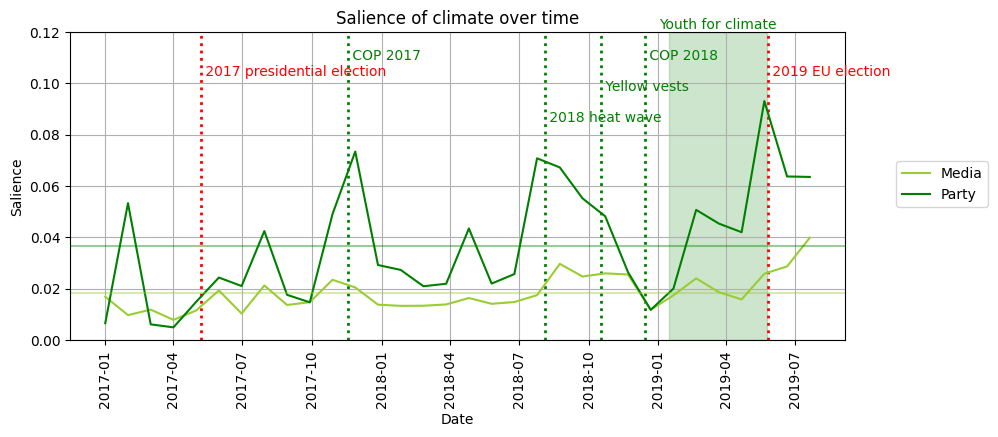

In [59]:
plot_salience('climate', max_y=0.12)



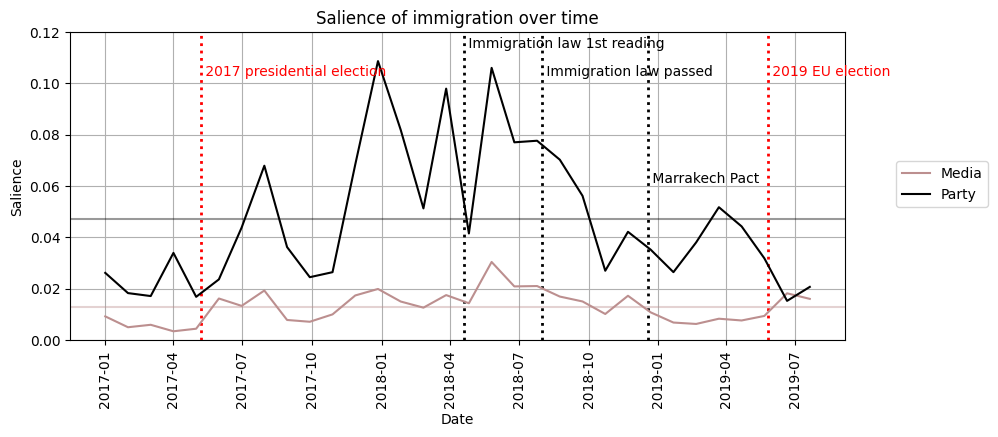

In [60]:
plot_salience('immigration', max_y=0.12)

# USERS & MEDIA

In [42]:
plot_df = df.copy()
plot_df = plot_df.set_index("start_date")

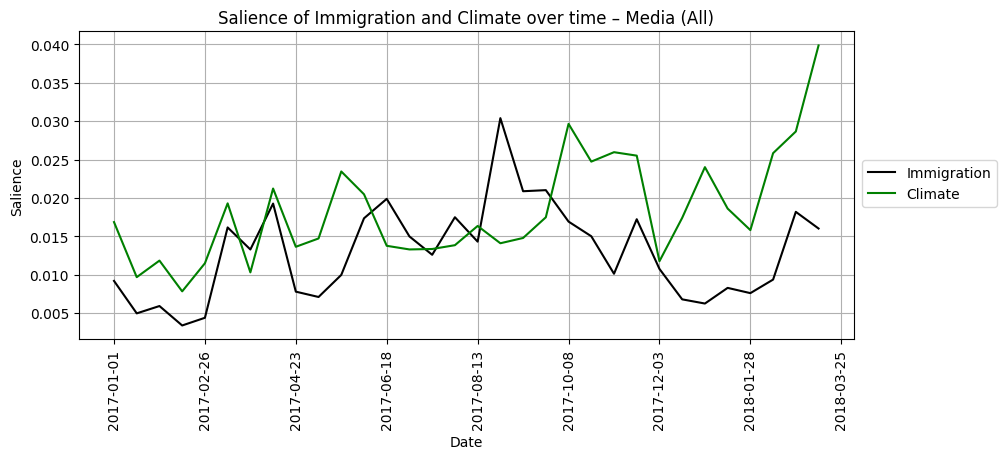

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df['imm_media_salience'], linestyle='-', color='black', label='Immigration')
ax1.plot(plot_df['clim_media_salience'], linestyle='-', color='green', label='Climate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salience', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.title(f'Salience of Immigration and Climate over time – Media (All)')
ax1.xaxis.set_major_locator(MultipleLocator(4))
plt.show()

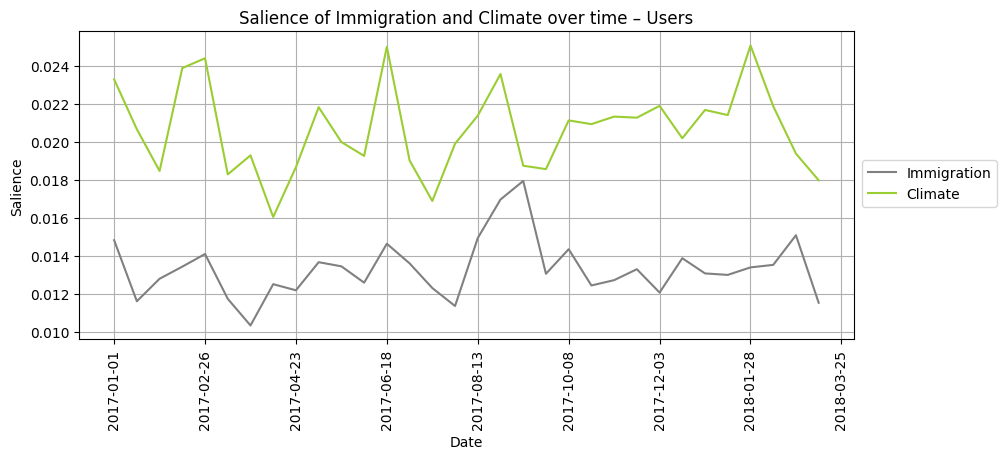

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df['imm_user_salience'], linestyle='-', color='gray', label='Immigration')
ax1.plot(plot_df['clim_user_salience'], linestyle='-', color='yellowgreen', label='Climate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salience', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.title(f'Salience of Immigration and Climate over time – Users')
ax1.xaxis.set_major_locator(MultipleLocator(4))
plt.show()

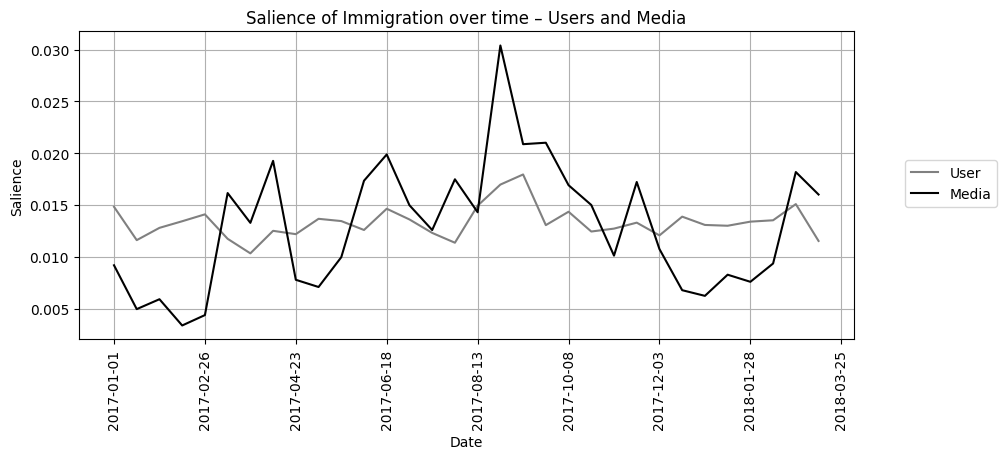

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df['imm_user_salience'], linestyle='-', color='gray', label='User')
ax1.plot(plot_df['imm_media_salience'], linestyle='-', color='black', label='Media')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salience', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.title(f'Salience of Immigration over time – Users and Media')
ax1.xaxis.set_major_locator(MultipleLocator(4))
plt.show()

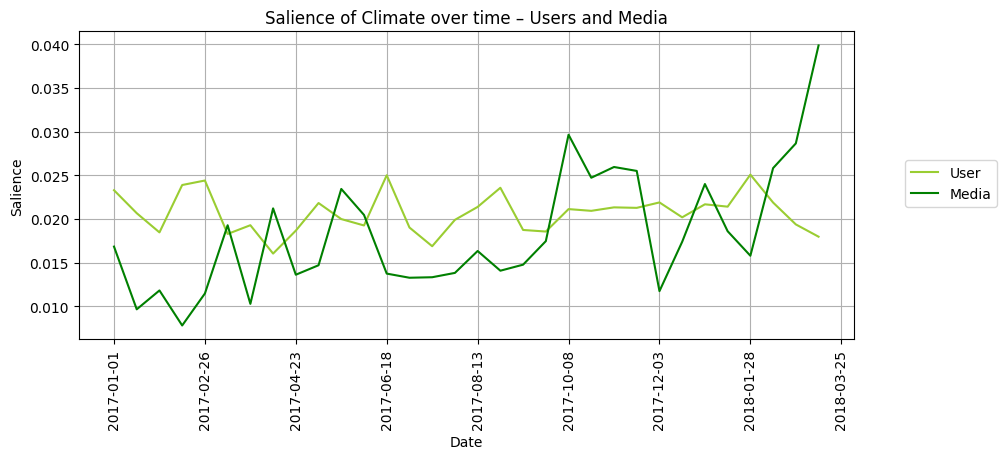

In [46]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df['clim_user_salience'], linestyle='-', color='yellowgreen', label='User')
ax1.plot(plot_df['clim_media_salience'], linestyle='-', color='green', label='Media')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salience', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.title(f'Salience of Climate over time – Users and Media')
ax1.xaxis.set_major_locator(MultipleLocator(4))
plt.show()

# PARTIES

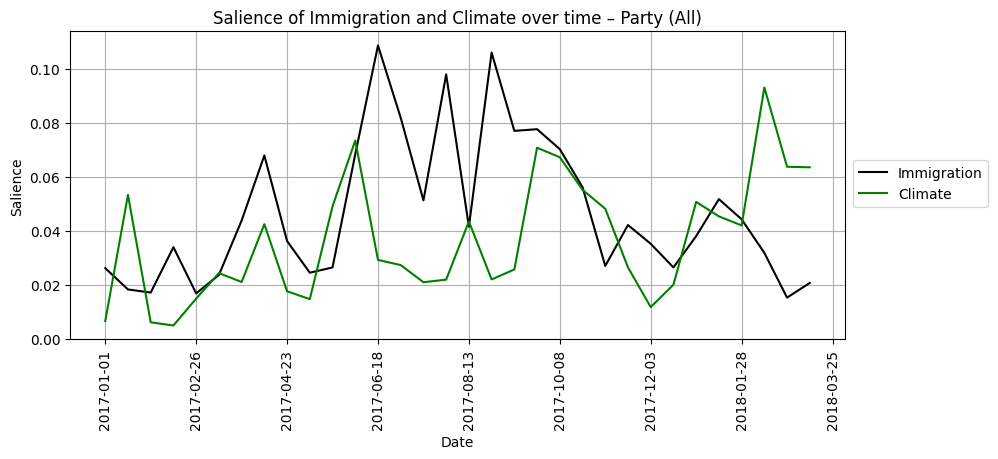

In [47]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df['imm_party_salience'], linestyle='-', color='black', label='Immigration')
ax1.plot(plot_df['clim_party_salience'], linestyle='-', color='green', label='Climate')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salience', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.title(f'Salience of Immigration and Climate over time – Party (All)')
ax1.xaxis.set_major_locator(MultipleLocator(4))
plt.show()

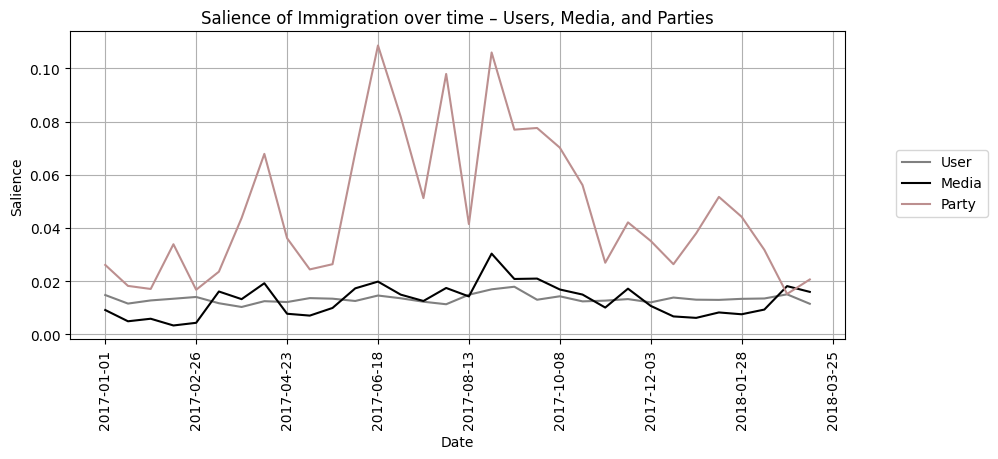

In [55]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df['imm_user_salience'], linestyle='-', color='gray', label='User')
ax1.plot(plot_df['imm_media_salience'], linestyle='-', color='black', label='Media')
ax1.plot(plot_df['imm_party_salience'], linestyle='-', color='rosybrown', label='Party')

ax1.set_xlabel('Date')
ax1.set_ylabel('Salience', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.title(f'Salience of Immigration over time – Users, Media, and Parties')
ax1.xaxis.set_major_locator(MultipleLocator(4))
plt.show()

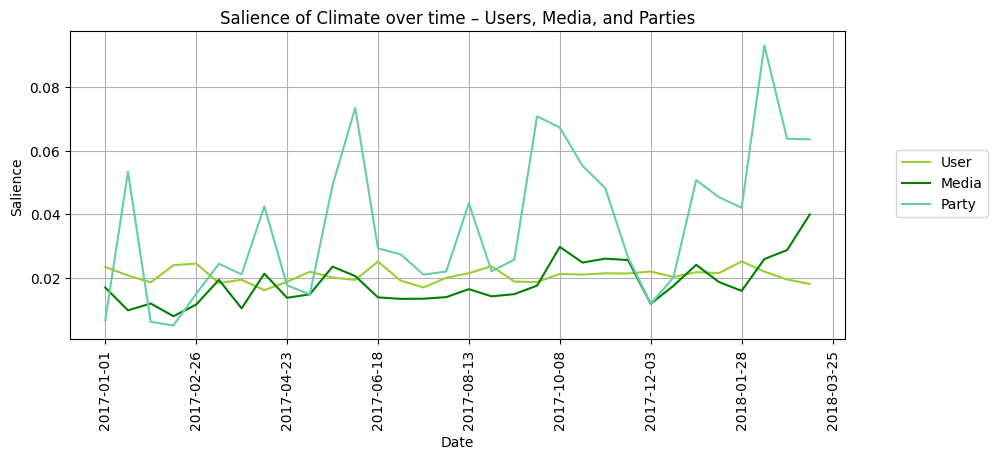

In [56]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df['clim_user_salience'], linestyle='-', color='yellowgreen', label='User')
ax1.plot(plot_df['clim_media_salience'], linestyle='-', color='green', label='Media')
ax1.plot(plot_df['clim_party_salience'], linestyle='-', color='mediumaquamarine', label='Party')

ax1.set_xlabel('Date')
ax1.set_ylabel('Salience', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

fig.legend(loc='right',bbox_to_anchor=(1.05,0.5))
plt.setp(ax1.get_xticklabels(), rotation=90)
plt.title(f'Salience of Climate over time – Users, Media, and Parties')
ax1.xaxis.set_major_locator(MultipleLocator(4))
plt.show()